<a href="https://colab.research.google.com/github/ProshkinNV/Time-series/blob/main/GitHub_Apple_Quotes_%E2%84%961.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Загрузка библиотек*

In [ ]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Построение моделей нейронных сетей
from keras.models import Sequential, Model

# Слои
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization
from keras.layers import Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D
from keras.layers import MaxPooling1D, RepeatVector

# Оптимизаторы
from keras.optimizers import Adam

# Генератор выборки временных рядов
from keras.preprocessing.sequence import TimeseriesGenerator

# Нормировка
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Отрисовка графиков
import matplotlib.pyplot as plt
import matplotlib.dates as dates

# импортируем автокорреляционную функцию (ACF)
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline

# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

# Отключение лишних предупреждений
import warnings
warnings.filterwarnings('ignore')

*Загрузка данных*

In [ ]:
# импортируем файл с данными о котировках акций Apple
!wget https://storage.yandexcloud.net/academy.ai/AAPL.csv

# Загрузим только необходимые колонки usecols, укажем, что колонку Date необходимо преобразовать в формат DateTime (parse_dates) и сделать индексом index_col
price = pd.read_csv("./AAPL.csv", index_col='Date', usecols = ['Adj Close', 'Date'], parse_dates=['Date'])

--2024-05-19 07:34:10--  https://storage.yandexcloud.net/academy.ai/AAPL.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186539 (182K) [text/csv]
Saving to: ‘AAPL.csv’

AAPL.csv            100%[===================>] 182.17K   318KB/s    in 0.6s    

2024-05-19 07:34:11 (318 KB/s) - ‘AAPL.csv’ saved [186539/186539]



In [ ]:
# Загрузим только необходимые колонки usecols, укажем, что колонку Date необходимо преобразовать в формат DateTime (parse_dates) и сделать индексом index_col
price = pd.read_csv("./AAPL.csv", index_col='Date', usecols = ['Adj Close', 'Date'], parse_dates=['Date'])

*Разбиение на обучающую и тестовую выборки*

In [ ]:
train_data = price[:'2023-01-10']
test_data = price['2023-01-20':]

*Нормарование данных*

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

*Генератор*

In [ ]:
n_input = 14  # Размерность входных данных
n_features = 1 # Размерность выходных данных
BATCH_SIZE = 2 # Размер пакета

generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=BATCH_SIZE)
print(f'Форма обучающего пакета: {generator[0][0].shape}, y: {generator[0][1].shape}')

Форма обучающего пакета: (2, 14, 1), y: (2, 1)


*Генерация выборок*

In [ ]:
validator = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=BATCH_SIZE)
print(f'Форма валидационного пакета: {validator[0][0].shape}, y: {validator[0][1].shape}')


tester = TimeseriesGenerator(scaled_test_data, scaled_test_data, length=n_input, batch_size=scaled_test_data.shape[0])
x_test, y_test = tester[0]
print(f'Форма тестовой выборки: {x_test.shape}, y: {y_test.shape}')

Форма валидационного пакета: (2, 14, 1), y: (2, 1)
Форма тестовой выборки: (285, 14, 1), y: (285, 1)


*Вспомогательные функции*

In [ ]:
# Объявление функции графика обучения
def history_plot(history, title):

    # Рисование графиков обучения
    fig = plt.figure(figsize=(14, 7))
    plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
    plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
    plt.title(f'{title}. График обучения')

    # Показываем только целые метки шкалы оси x
    fig.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

# Функция расчета корреляции для двух рядов
def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true,title=''):

    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед
    plt.plot(y_pred[1:], label=f'Прогноз')
    plt.plot(y_true[:-1], label=f'Базовый')
    #plt.plot(x_date)
    plt.title(title)

    # Показываем только целые метки шкалы оси x
    #plt.gca().xaxis.get_major_locator(x_date)
    #plt.gca().xaxis.get_major_formatter(dates.DateFormatter('%d\n\n%a'))
    #plt.gca().invert_xaxis()
    plt.xlabel('Дата (относительно начала выборки)')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

# Функция расчета результата предсказания
def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test, verbose=0))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled



# Функция рисования корреляций прогнозного ряда и исходного со смещением
# break_step - ограничитель на число временных лагов

def show_corr(y_pred, y_true, title='', break_step=30):

    # выбираем наименьшее из длины y_len и break_step в качестве числа лагов для графика
    y_len = y_true.shape[0]
    steps = range(1, np.min([y_len+1, break_step+1]))

    # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
    cross_corr = [correlate(y_true[:-step, 0], y_pred[step:, 0]) for step in steps]

    # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
    auto_corr = [correlate(y_true[:-step, 0], y_true[step:, 0]) for step in steps]

    plt.plot(steps, cross_corr, label=f'Прогноз')
    plt.plot(steps, auto_corr, label=f'Эталон')

    plt.title(title)

    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

*Callback*


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
early_stop = EarlyStopping(monitor = 'loss', min_delta = 0.00001, patience= 10, verbose = 1,restore_best_weights=True)
callbacks = [early_stop]

*Архитектура сети*

In [ ]:
model = Sequential()
model.add(Dense(25, input_shape=generator[0][0].shape[1:], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Flatten())
model.add(Dense(n_features, activation='linear'))
model.compile(optimizer='adam', loss='mse')

*Обучение сети*

In [ ]:
history = model.fit_generator(generator, epochs=30, validation_data=validator)

Epoch 1/30
1129/1129 [==============================] - 6s 5ms/step - loss: 2.0765e-04 - val_loss: 0.0024
Epoch 2/30
1129/1129 [==============================] - 4s 4ms/step - loss: 2.4608e-04 - val_loss: 2.8680e-04
Epoch 3/30
1129/1129 [==============================] - 4s 3ms/step - loss: 2.4168e-04 - val_loss: 2.3123e-04
Epoch 4/30
1129/1129 [==============================] - 5s 4ms/step - loss: 1.9732e-04 - val_loss: 4.7898e-04
Epoch 5/30
1129/1129 [==============================] - 4s 3ms/step - loss: 2.1294e-04 - val_loss: 2.2957e-04
Epoch 6/30
1129/1129 [==============================] - 4s 3ms/step - loss: 2.0194e-04 - val_loss: 2.1799e-04
Epoch 7/30
1129/1129 [==============================] - 5s 4ms/step - loss: 2.1615e-04 - val_loss: 0.0012
Epoch 8/30
1129/1129 [==============================] - 4s 3ms/step - loss: 2.4519e-04 - val_loss: 3.3813e-04
Epoch 9/30
1129/1129 [==============================] - 4s 3ms/step - loss: 2.0452e-04 - val_loss: 7.8675e-04
Epoch 10/30
1129/1

*Визуализация графиков*

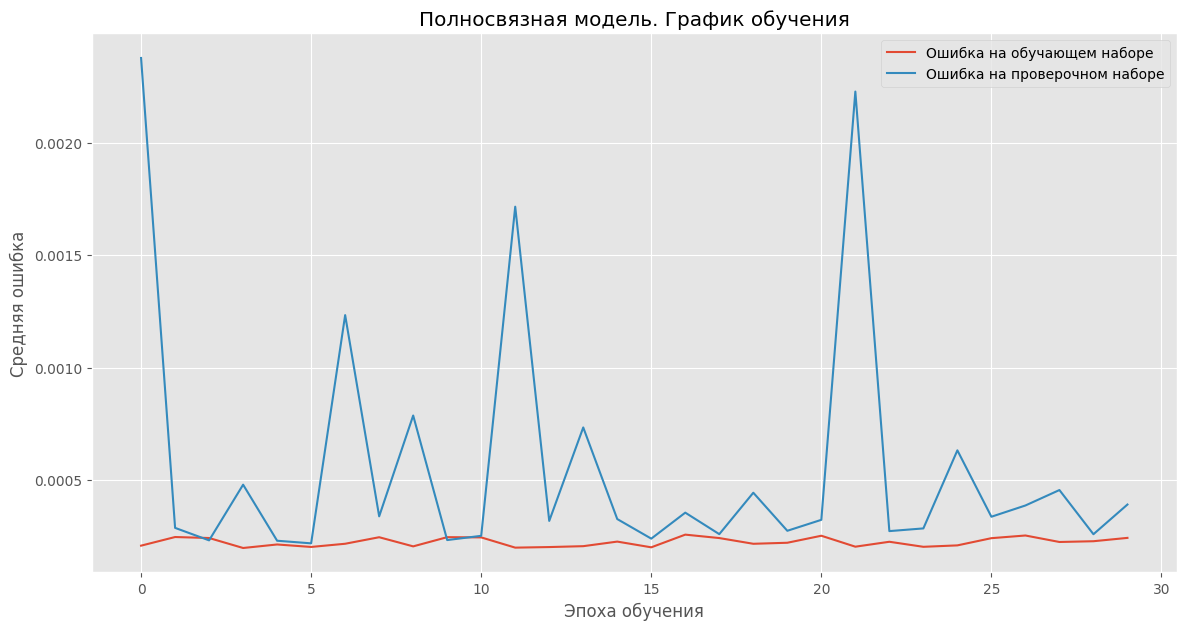

In [ ]:
history_plot(history, 'Полносвязная модель')

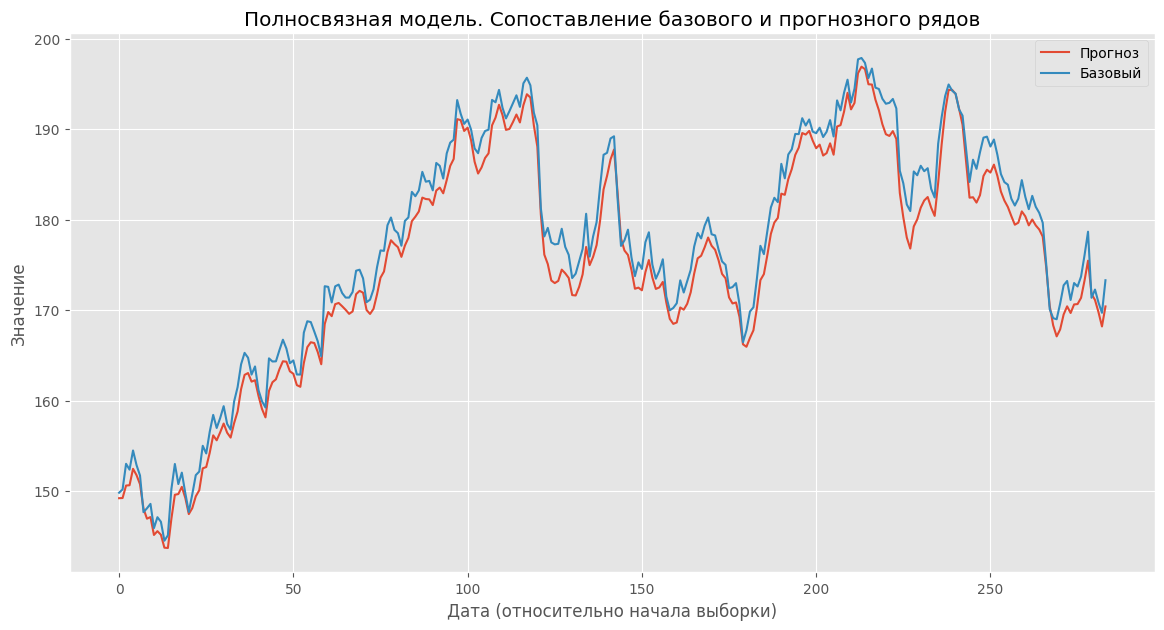

In [ ]:
# Получение денормализованного предсказания и данных базового ряда
y_pred, y_true = get_pred(model, x_test, y_test, scaler)

# Отрисовка графика сопоставления базового и прогнозного рядов
show_predict(y_pred, y_true, title=f'Полносвязная модель. Сопоставление базового и прогнозного рядов')

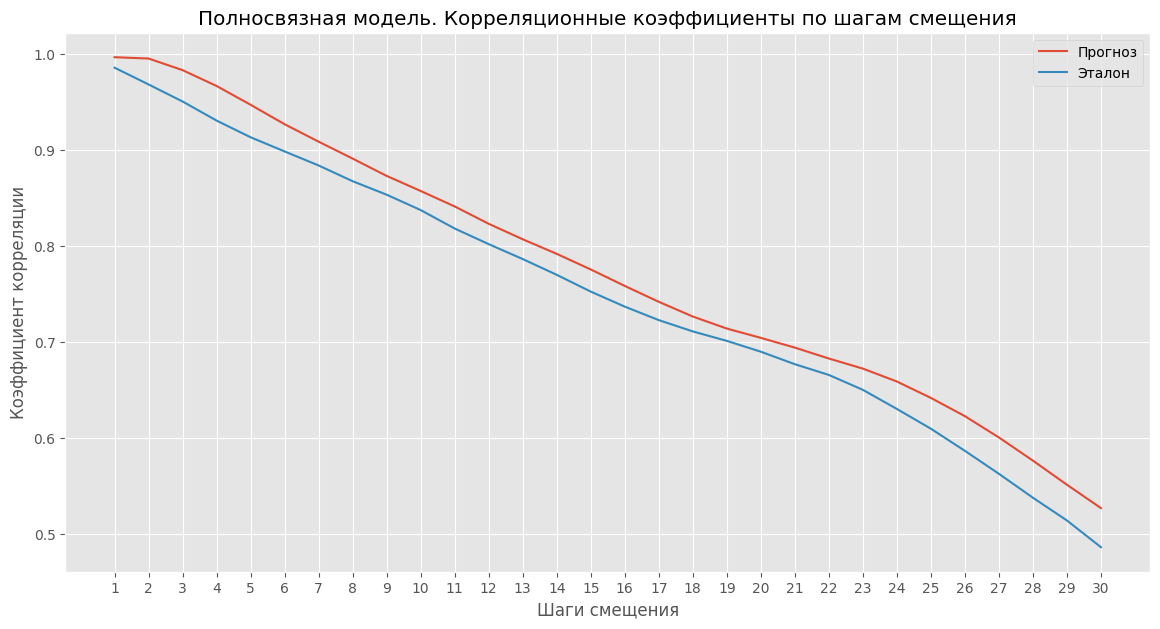

In [ ]:
# Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
show_corr(y_pred, y_true, title=f'Полносвязная модель. Корреляционные коэффициенты по шагам смещения')

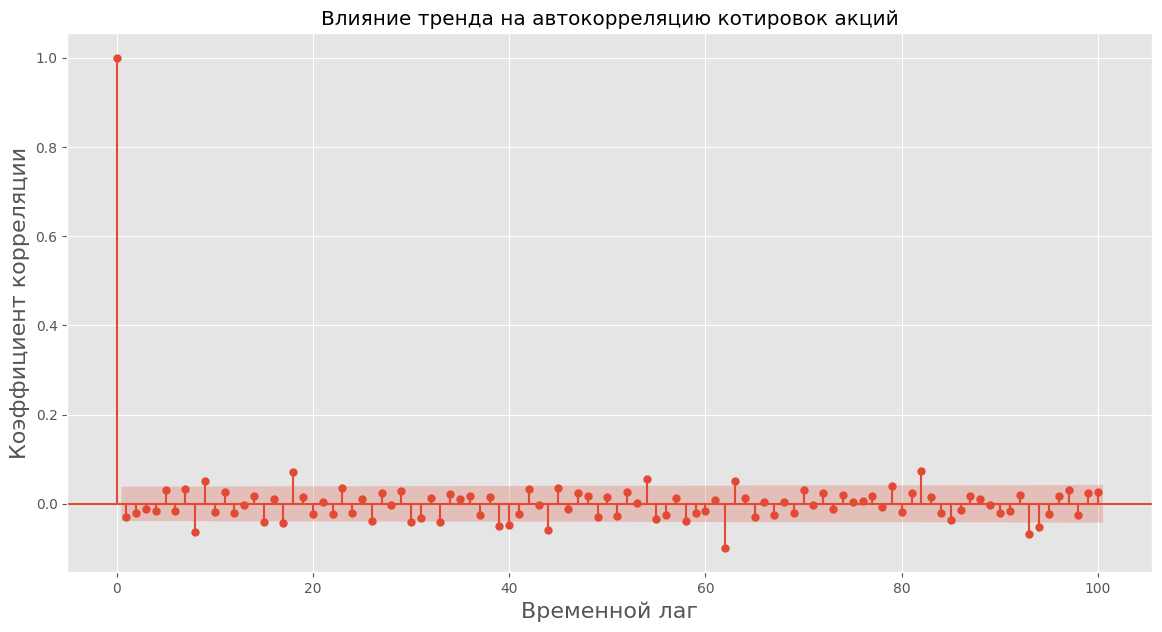

In [ ]:
plot_acf(np.diff(price['Adj Close']), lags = 100)
plt.axis('tight')
plt.title('Влияние тренда на автокорреляцию котировок акций')
plt.xlabel('Временной лаг', fontsize = 16)
plt.ylabel('Коэффициент корреляции', fontsize = 16)
plt.show()